### **Importing libraries**

In [1]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
warnings.filterwarnings('ignore')
import nltk
from nltk.tokenize import word_tokenize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from nltk.corpus import stopwords
from keras.preprocessing import text, sequence
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D


### **Integrating with google drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Data Loading**

In [3]:
header_list = ["ID", "label", "statement","subject","speaker","title of speaker","state","party","barely true","false","half true","mostly true","pants on fire","venue"]

In [4]:
train_dataset = pd.read_csv("/content/drive/MyDrive/MLProject/train.tsv",delimiter='\t',names=header_list)
valid_dataset = pd.read_csv("/content/drive/MyDrive/MLProject/valid.tsv",delimiter='\t',names=header_list)
test_dataset = pd.read_csv("/content/drive/MyDrive/MLProject/test.tsv",delimiter='\t',names=header_list)

In [5]:
print(train_dataset.shape)
print(valid_dataset.shape)
print(test_dataset.shape)

(10240, 14)
(1284, 14)
(1267, 14)


In [6]:
Dataset = pd.concat([train_dataset,valid_dataset,test_dataset], ignore_index=True)

### **Dataset Statistics and Visulization**

In [7]:
Dataset

,ID,label,statement,subject,speaker,title of speaker,state,party,barely true,false,half true,mostly true,pants on fire,venue
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12786,7334.json,half-true,Says his budget provides the highest state fun...,education,rick-scott,Governor,Florida,republican,28.0,23.0,38.0,34.0,7.0,a news conference
12787,9788.json,barely-true,Ive been here almost every day.,"civil-rights,crime,criminal-justice",jay-nixon,Governor,Missouri,democrat,2.0,0.0,0.0,1.0,0.0,"on ABC's ""This Week"""
12788,10710.json,barely-true,"In the early 1980s, Sen. Edward Kennedy secret...","bipartisanship,congress,foreign-policy,history",mackubin-thomas-owens,"senior fellow, Foreign Policy Research Institute",Rhode Island,columnist,1.0,0.0,0.0,0.0,0.0,a commentary in The Providence Journal
12789,3186.json,barely-true,Says an EPA permit languished under Strickland...,"environment,government-efficiency",john-kasich,"Governor of Ohio as of Jan. 10, 2011",Ohio,republican,9.0,8.0,10.0,18.0,3.0,a news conference


In [8]:
Dataset.shape

(12791, 14)

In [9]:
columns = Dataset.columns
columns

Index(['ID', 'label', 'statement', 'subject', 'speaker', 'title of speaker',
       'state', 'party', 'barely true', 'false', 'half true', 'mostly true',
       'pants on fire', 'venue'],
      dtype='object')

In [10]:
Dataset['label'].value_counts()

half-true      2627
false          2507
mostly-true    2454
barely-true    2103
true           2053
pants-fire     1047
Name: label, dtype: int64

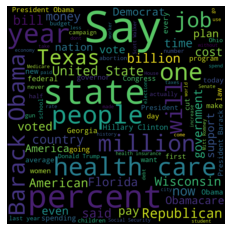

In [11]:
wc = WordCloud(background_color="black", max_words=100,
               max_font_size=200,
               random_state=42, width=1000, height=1000)
wc.generate(' '.join(Dataset['statement']))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

### **Data Preprocessing**

In [12]:
Dataset.head(10)

,ID,label,statement,subject,speaker,title of speaker,state,party,barely true,false,half true,mostly true,pants on fire,venue
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
5,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece
6,2342.json,barely-true,Jim Dunnam has not lived in the district he re...,candidates-biography,republican-party-texas,NaN,Texas,republican,3.0,1.0,1.0,3.0,1.0,a press release.
7,153.json,half-true,I'm the only person on this stage who has work...,ethics,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,"a Democratic debate in Philadelphia, Pa."
8,5602.json,half-true,"However, it took $19.5 million in Oregon Lotte...",jobs,oregon-lottery,NaN,NaN,organization,0.0,0.0,1.0,0.0,1.0,a website
9,9741.json,mostly-true,Says GOP primary opponents Glenn Grothman and ...,"energy,message-machine-2014,voting-record",duey-stroebel,State representative,Wisconsin,republican,0.0,0.0,0.0,1.0,0.0,an online video


In [13]:
new_Dataset = Dataset[['statement','label']]

In [14]:
new_Dataset.head()

,statement,label
0,Says the Annies List political group supports ...,false
1,When did the decline of coal start? It started...,half-true
2,"Hillary Clinton agrees with John McCain ""by vo...",mostly-true
3,Health care reform legislation is likely to ma...,false
4,The economic turnaround started at the end of ...,half-true


In [15]:
new_Dataset.isnull().sum()

statement    0
label        0
dtype: int64

In [16]:
new_Dataset['label'].value_counts()

half-true      2627
false          2507
mostly-true    2454
barely-true    2103
true           2053
pants-fire     1047
Name: label, dtype: int64

### **Removing stop words and lemmatization**



In [17]:
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
wordnet_lemmatizer = WordNetLemmatizer()

In [20]:
for i in range(new_Dataset.shape[0]):
    new_Dataset['statement'][i] = re.sub('[^A-Za-z ]+', '',new_Dataset['statement'][i])
    words = word_tokenize(new_Dataset['statement'][i])
    words = [wordnet_lemmatizer.lemmatize(word.lower(), pos='v') for word in words if word not in set(stopwords.words('english'))]
    new_Dataset['statement'][i] = ' '.join(words)


In [22]:
X = new_Dataset['statement'].values
Y = pd.get_dummies(new_Dataset['label']).values
print('Shape of label tensor:', Y.shape)


Shape of label tensor: (12791, 6)


In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(10232,) (10232, 6)
(2559,) (2559, 6)


### **Vectorizing statements**

*Vectorize statements, by turning each statement into either a sequence of integers or into a vector.*

In [24]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train) #creating Vocabulory

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(X_train[2])
print(X_train[2])

[413, 400, 221, 3344, 14, 995, 2072, 2, 40]
[413, 400, 221, 3344, 14, 995, 2072, 2, 40]


*Set the max number of words in each statement at 50.*

In [25]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 50

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[   1    2  234 2871  240  489  338  664  289    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


### **Glove embedding**

In [26]:
embedding_dim = 200

embedding_matrix = np.zeros((vocab_size, embedding_dim))
word_index = tokenizer.word_index

with open('/content/drive/MyDrive/MLProject/glove.6B.200d.txt') as f:
  for line in f:
    word,*vector = line.split()
    if word in word_index:
      i = word_index[word] 
      embedding_matrix[i] = np.array(vector, dtype=np.float32)[:embedding_dim]

In [27]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.85908203125

### **Building the model**

In [28]:
from keras import layers

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen,
                           trainable = True))
model.add(LSTM(100))
model.add(layers.Dense(6, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 200)           2048000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               120400    
_________________________________________________________________
dense (Dense)                (None, 6)                 606       
Total params: 2,169,006
Trainable params: 2,169,006
Non-trainable params: 0
_________________________________________________________________


### **Fitting and saving the model**

In [29]:
history = model.fit(X_train, Y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, Y_test),
                    batch_size=64)


In [30]:
model.save('/content/drive/MyDrive/MLProject/lstm_model.h5')

### **Finding Accuracy**

In [31]:

print("Training Accuracy: %0.3f"%model.evaluate(X_train, Y_train, verbose=False)[1])
 
print("Testing Accuracy: %0.3f"%model.evaluate(X_test, Y_test, verbose=False)[1])

Training Accuracy: 0.888
Testing Accuracy: 0.216


### **Generating Confusion matrix**

In [34]:
predictions = model.predict_classes(X_test)

In [35]:
predictions

array([0, 3, 3, ..., 1, 5, 1])

In [39]:
rounded_labels=np.argmax(Y_test, axis=1)
rounded_labels

array([0, 5, 0, ..., 1, 5, 2])

In [40]:
from sklearn.metrics import multilabel_confusion_matrix
CM = multilabel_confusion_matrix(rounded_labels, predictions)
print(CM)

[[[1730  389]
  [ 347   93]]

 [[1720  341]
  [ 396  102]]

 [[1420  581]
  [ 384  174]]

 [[1706  362]
  [ 402   89]]

 [[2274   87]
  [ 166   32]]

 [[1939  246]
  [ 311   63]]]


In [44]:
#importing confusion matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(rounded_labels, predictions)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[ 93  68 134  74  22  49]
 [103 102 140  82  27  44]
 [ 98  86 174 100  16  84]
 [ 87  96 148  89  12  59]
 [ 42  33  60  21  32  10]
 [ 59  58  99  85  10  63]]


In [46]:
#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(rounded_labels, predictions)))

print('Micro Precision: {:.2f}'.format(precision_score(rounded_labels, predictions, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(rounded_labels, predictions, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(rounded_labels, predictions, average='micro')))



from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(rounded_labels, predictions, target_names=['Class 0', 'Class 1', 'Class 2','Class 3','Class 4','Class 5']))


Accuracy: 0.22

Micro Precision: 0.22
Micro Recall: 0.22
Micro F1-score: 0.22


Classification Report

              precision    recall  f1-score   support

     Class 0       0.19      0.21      0.20       440
     Class 1       0.23      0.20      0.22       498
     Class 2       0.23      0.31      0.27       558
     Class 3       0.20      0.18      0.19       491
     Class 4       0.27      0.16      0.20       198
     Class 5       0.20      0.17      0.18       374

    accuracy                           0.22      2559
   macro avg       0.22      0.21      0.21      2559
weighted avg       0.22      0.22      0.21      2559

